Estación UIS01 → Mediana global de promedios absolutos: 9.19


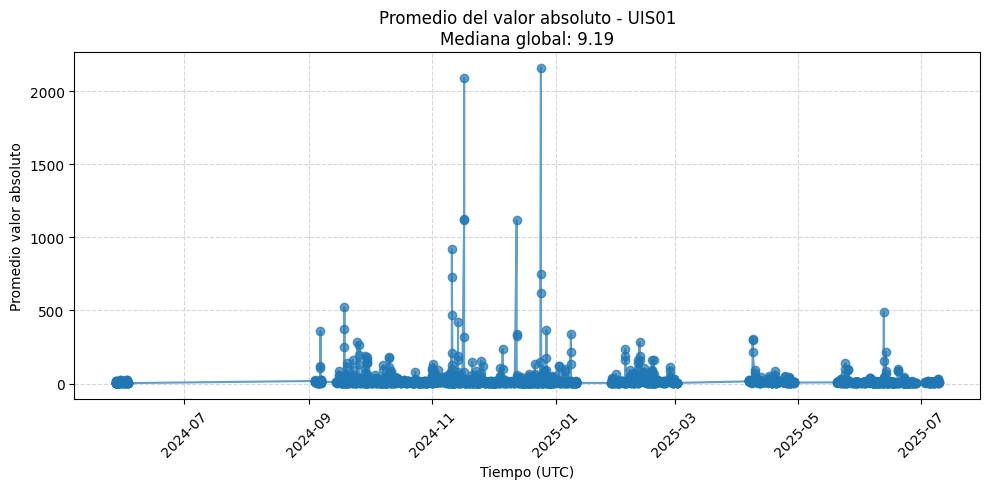

Estación UIS03 → Mediana global de promedios absolutos: 3.42


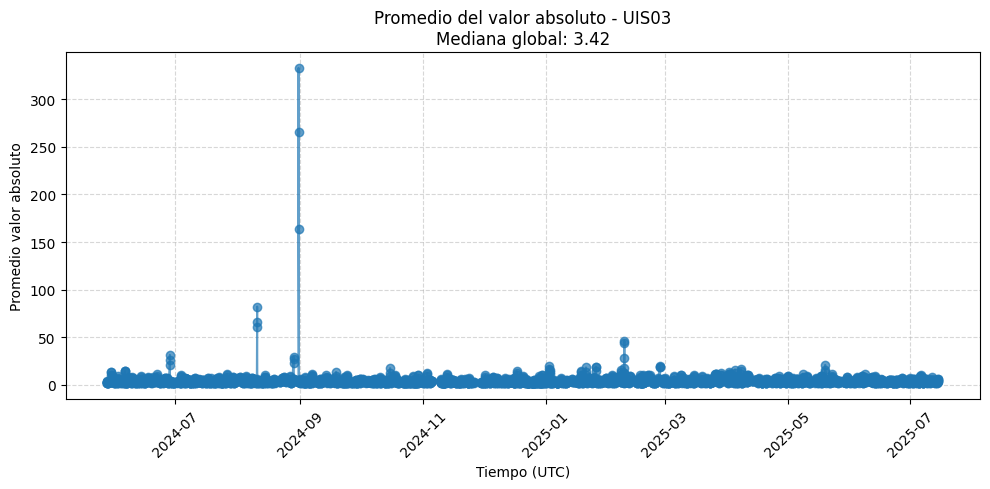

Estación UIS04 → Mediana global de promedios absolutos: 6.60


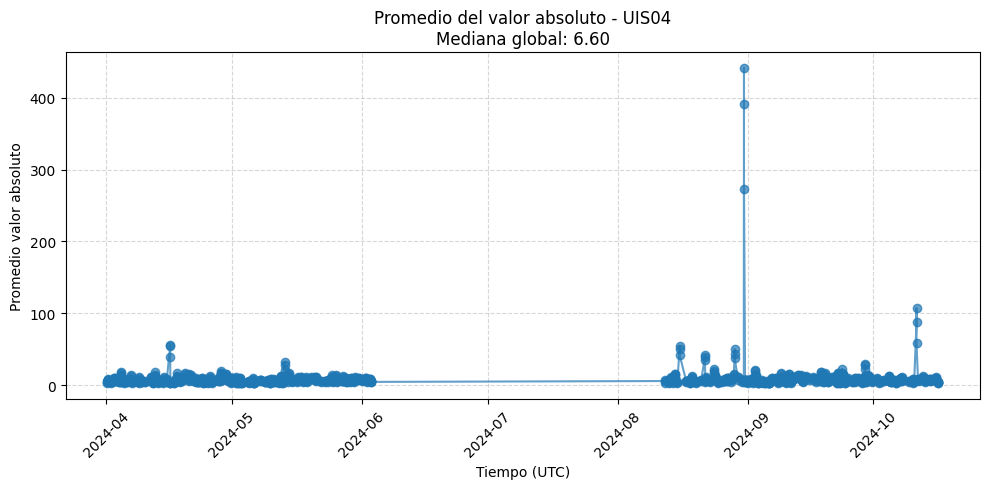

Estación UIS09 → Mediana global de promedios absolutos: 10.61


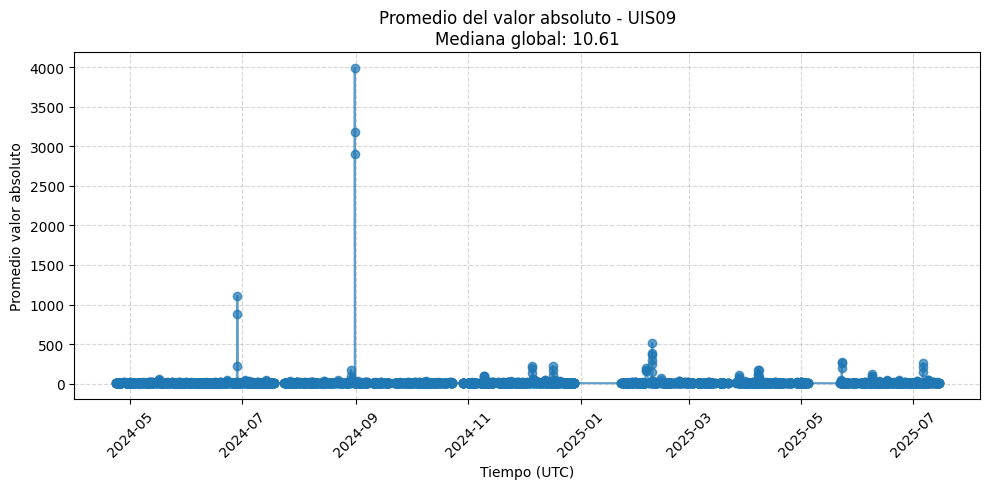

Estación UIS11 → Mediana global de promedios absolutos: 23.03


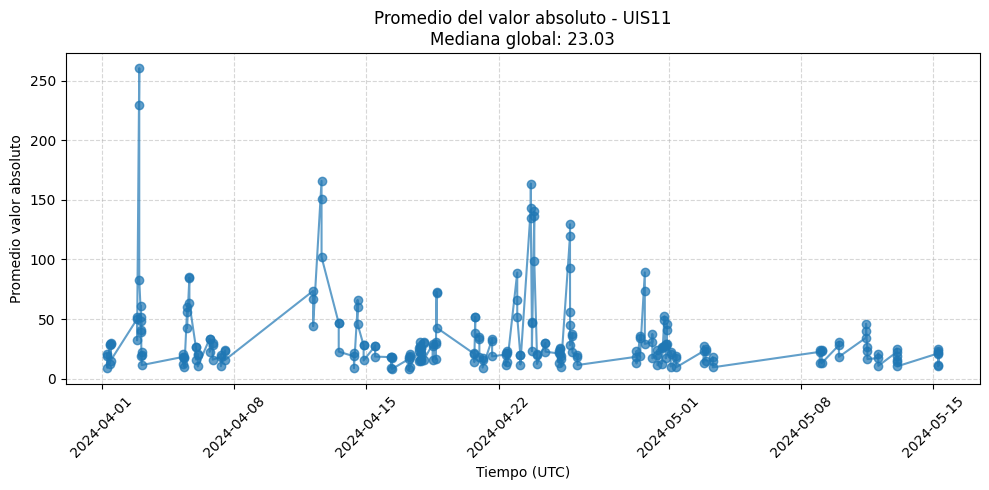

Estación UIS05_acceleration → Mediana global de promedios absolutos: 1046.80


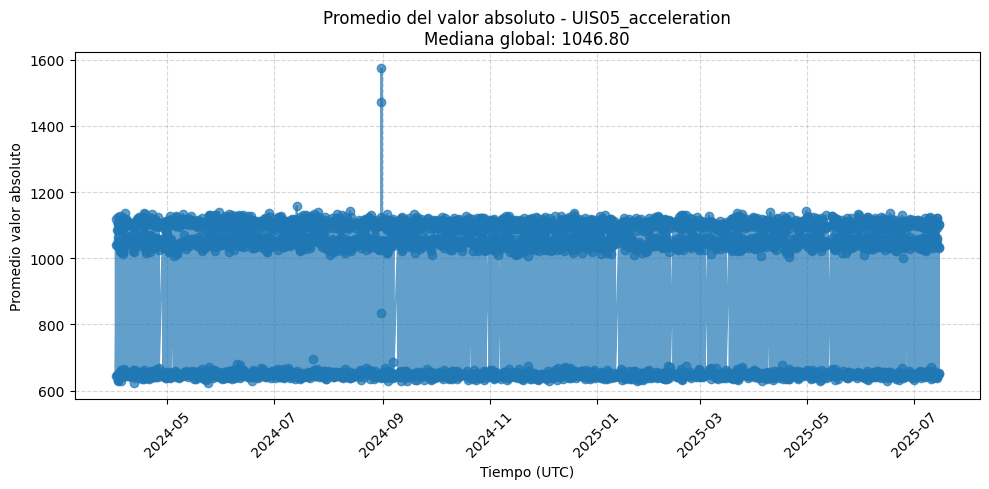

Estación UIS05_velocity → Mediana global de promedios absolutos: 101.34


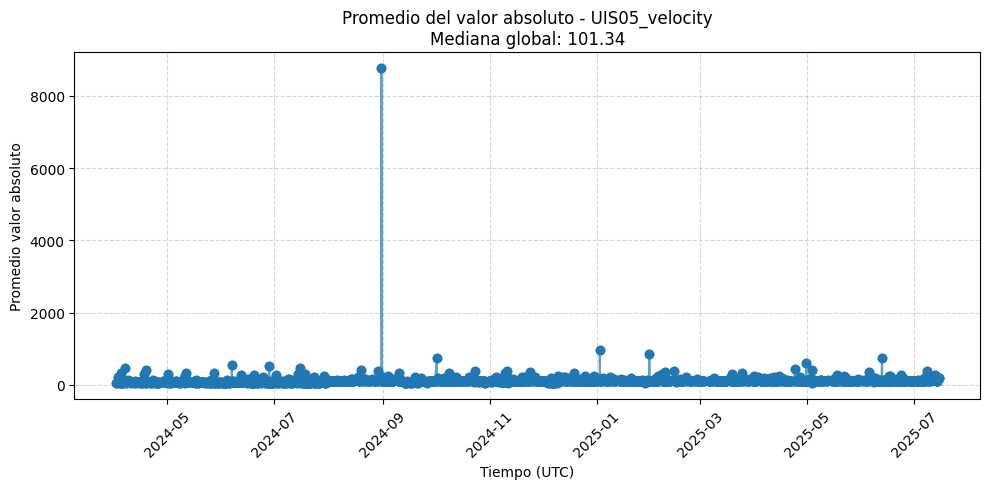

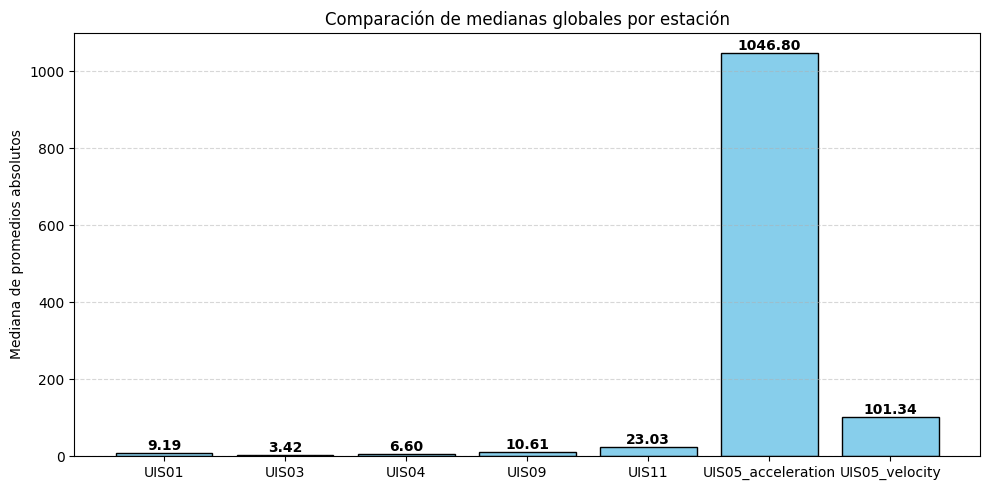

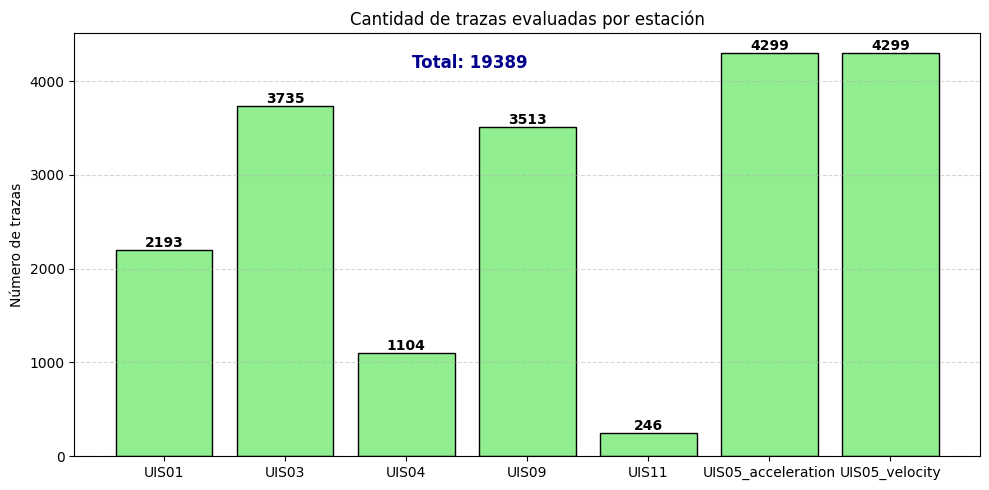

: 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from datetime import datetime

# Carpeta con los archivos mseed
input_folder = "D_REDNE_mseed_tendencia_media_noise"

# Estaciones de interés
stations = ["UIS01", "UIS03", "UIS04", "UIS05", "UIS09", "UIS11"]

# Diccionario para guardar valores por estación (y sensor type en caso de UIS05)
station_data = {st: [] for st in stations}
station_data["UIS05_acceleration"] = []
station_data["UIS05_velocity"] = []

# Función para extraer fecha del nombre del archivo
def extract_time_from_filename(filename):
    parts = filename.split("_")
    start_time = None
    try:
        if parts[2][0:4].isdigit():
            start_time_str = parts[2]
            start_time = datetime.strptime(start_time_str, "%Y-%m-%dT%H-%M-%S")
        elif parts[4][0:4].isdigit():
            start_time_str = parts[4]
            start_time = datetime.strptime(start_time_str, "%Y-%m-%dT%H-%M-%S")
    except Exception as e:
        print(f"No pude extraer tiempo de {filename}: {e}")
    return start_time

# Recorremos los archivos en la carpeta
for filename in os.listdir(input_folder):
    if filename.endswith(".mseed"):
        filepath = os.path.join(input_folder, filename)
        try:
            st = read(filepath)
            for tr in st:
                data = tr.data.astype(float)
                mean_abs = np.mean(np.abs(data))
                start_time = extract_time_from_filename(filename)
                if start_time is None:
                    continue
                if "UIS05" in filename:
                    if "acceleration" in filename:
                        station_data["UIS05_acceleration"].append((start_time, mean_abs))
                    elif "velocity" in filename:
                        station_data["UIS05_velocity"].append((start_time, mean_abs))
                    else:
                        station_data["UIS05"].append((start_time, mean_abs))
                else:
                    for station in stations:
                        if station in filename:
                            station_data[station].append((start_time, mean_abs))
                            break
        except Exception as e:
            print(f"Error leyendo {filename}: {e}")

# --- Visualización y cálculo de estadísticas ---
medianas = {}  # Para guardar la mediana por estación

for station, data in station_data.items():
    if not data:
        continue

    # Ordenar por tiempo
    data = sorted(data, key=lambda x: x[0])
    times = [d[0] for d in data]
    values = [d[1] for d in data]

    # Calcular mediana
    median_station = np.median(values)
    medianas[station] = median_station
    print(f"Estación {station} → Mediana global de promedios absolutos: {median_station:.2f}")

    # Graficar por estación
    plt.figure(figsize=(10,5))
    plt.plot(times, values, 'o-', alpha=0.7)
    plt.title(f"Promedio del valor absoluto - {station}\nMediana global: {median_station:.2f}")
    plt.xlabel("Tiempo (UTC)")
    plt.ylabel("Promedio valor absoluto")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- Gráfico comparativo de medianas ---
plt.figure(figsize=(10,5))
stations_labels = list(medianas.keys())
median_values = list(medianas.values())

bars = plt.bar(stations_labels, median_values, color="skyblue", edgecolor="black")

plt.title("Comparación de medianas globales por estación")
plt.ylabel("Mediana de promedios absolutos")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Añadir valores encima de cada barra
for bar, value in zip(bars, median_values):
    plt.text(
        bar.get_x() + bar.get_width()/2,   # posición x (centro de la barra)
        bar.get_height(),                  # posición y (encima de la barra)
        f"{value:.2f}",                    # texto (2 decimales)
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.tight_layout()
plt.show()


# --- Gráfico de cantidad de trazas evaluadas por estación ---
plt.figure(figsize=(10,5))

# Usamos todas las claves de station_data que tengan datos
stations_labels = [st for st, data in station_data.items() if data]
trace_counts = [len(station_data[st]) for st in stations_labels]

bars = plt.bar(stations_labels, trace_counts, color="lightgreen", edgecolor="black")

plt.title("Cantidad de trazas evaluadas por estación")
plt.ylabel("Número de trazas")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Añadir valores encima de cada barra
for bar, count in zip(bars, trace_counts):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        str(count),
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

# Calcular total de trazas
total_traces = sum(trace_counts)

# Mostrar total en la esquina superior derecha del gráfico
plt.text(
    0.5, 0.95,
    f"Total: {total_traces}",
    ha="right", va="top",
    transform=plt.gca().transAxes,
    fontsize=12, fontweight="bold", color="darkblue"
)

plt.tight_layout()
plt.show()



In [ ]:
import os
from datetime import timedelta
from collections import defaultdict

from obspy import read
from obspy.signal.trigger import classic_sta_lta_py, trigger_onset

# --------------------------- PARÁMETROS ---------------------------------- #
DATA_DIR = "D_REDNE_mseed_tendencia_media"   # Carpeta con los .mseed
STA_SECONDS = 1
LTA_SECONDS = 30          # <--- puedes mover este valor
TH_OFF = 1.6
TH_ON_DEFAULT = 4
TH_ON_LOW = 3           # <--- puedes mover este valor
TH_ON_HIGH = 6            # <--- puedes mover este valor
# ------------------------------------------------------------------------- #

def detectar_eventos(traza, th_on):
    """Devuelve lista de tiempos (datetime) donde se detectan eventos."""
    n_sta = int(STA_SECONDS * traza.stats.sampling_rate)
    n_lta = int(LTA_SECONDS * traza.stats.sampling_rate)
    cft = classic_sta_lta_py(traza.data, n_sta, n_lta)
    on_off = trigger_onset(cft, th_on, TH_OFF)
    base_time = traza.stats.starttime.datetime
    return [base_time + timedelta(seconds=traza.times()[idx_on]) for idx_on, _ in on_off]

def procesar_archivo(path, th_on):
    """Devuelve (canal_id, lista_eventos) usando solo la primera traza."""
    st = read(path)
    tr = st[0]
    eventos = detectar_eventos(tr, th_on)
    return tr.id, eventos

def extraer_estacion(fname):
    """Extrae la estación del nombre de archivo."""
    # Ejemplo: processed_UIS01_2024-05-28T02-55-02_2024-05-28T02-57-02.mseed
    parts = fname.split("_")
    for p in parts:
        if p.startswith("UIS"):  # ajusta si tus estaciones tienen otro prefijo
            return p
    return "DESCONOCIDA"

def main():
    archivos = sorted(f for f in os.listdir(DATA_DIR) if f.lower().endswith(".mseed"))

    # Diccionario de grupos → { estacion : conteo }
    grupos = {
        0: defaultdict(int),
        1: defaultdict(int),
        2: defaultdict(int),
        3: defaultdict(int),
        "4+": defaultdict(int),
    }

    total_archivos = 0

    for fname in archivos:
        path = os.path.join(DATA_DIR, fname)

        try:
            canal_id, eventos = procesar_archivo(path, TH_ON_DEFAULT)
        except Exception as exc:
            print(f"[ERROR] {fname}: {exc}")
            continue

        total_archivos += 1
        total_inicial = len(eventos)

        # Reprocesar según la cantidad inicial de eventos
        if total_inicial == 1:
            _, eventos = procesar_archivo(path, TH_ON_LOW)
        elif total_inicial >= 3:
            _, eventos = procesar_archivo(path, TH_ON_HIGH)

        total_final = len(eventos)
        estacion = extraer_estacion(fname)

        if total_final == 0:
            grupos[0][estacion] += 1
        elif total_final == 1:
            grupos[1][estacion] += 1
        elif total_final == 2:
            grupos[2][estacion] += 1
        elif total_final == 3:
            grupos[3][estacion] += 1
        else:
            grupos["4+"][estacion] += 1

    # Resumen global
    print("\n============= RESUMEN GLOBAL =============")
    print(f"Total de archivos analizados : {total_archivos}")

    for k in [0, 1, 2, 3, "4+"]:
        total_grupo = sum(grupos[k].values())
        print(f"\nArchivos con {k} eventos : {total_grupo}")
        '''
        for estacion, count in sorted(grupos[k].items()):
            print(f"   {estacion} : {count} mseed")    
        '''    
        
        

if __name__ == "__main__":
    main()



============= RESUMEN GLOBAL =============
Total de archivos analizados : 6471

Archivos con 0 eventos : 1628

Archivos con 1 eventos : 556

Archivos con 2 eventos : 3922

Archivos con 3 eventos : 297

Archivos con 4+ eventos : 68


Estación UIS01 → Mediana global de promedios absolutos: 41.27


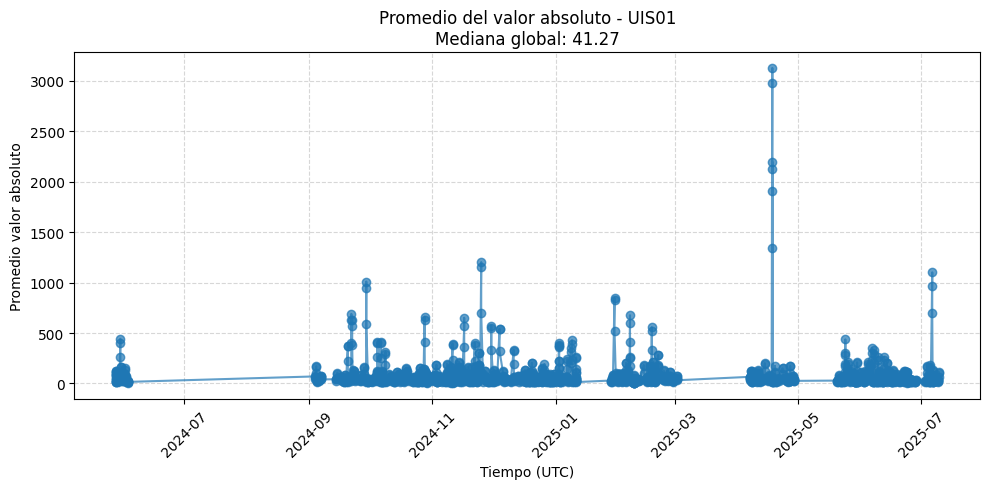

Estación UIS03 → Mediana global de promedios absolutos: 7.03


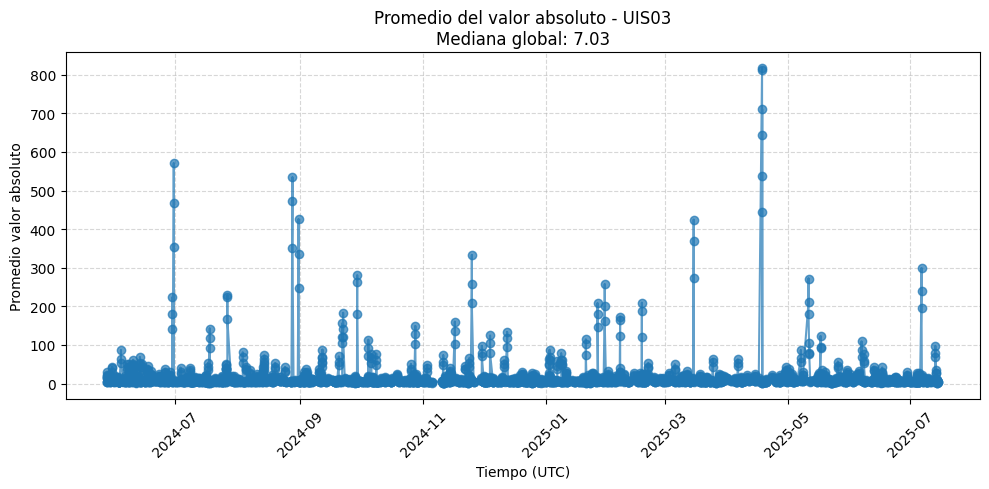

Estación UIS04 → Mediana global de promedios absolutos: 16.10


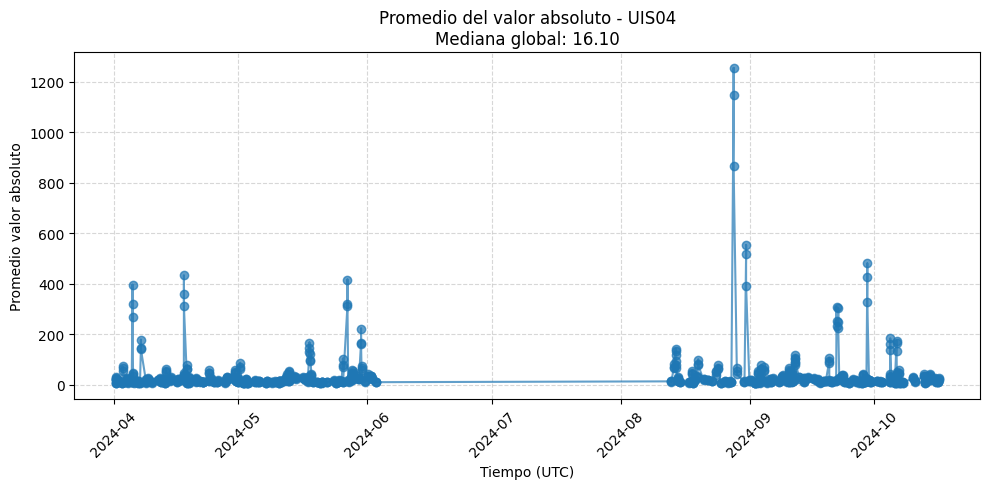

Estación UIS09 → Mediana global de promedios absolutos: 65.60


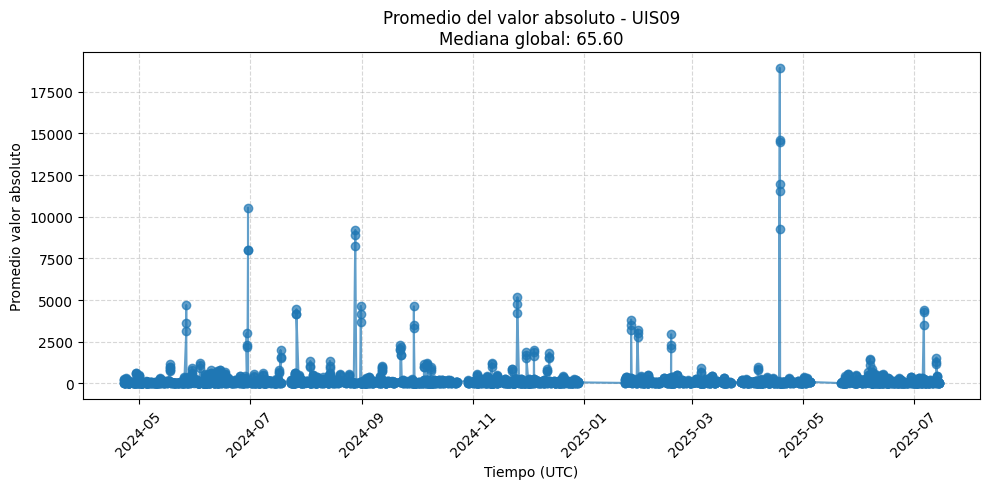

Estación UIS11 → Mediana global de promedios absolutos: 123.75


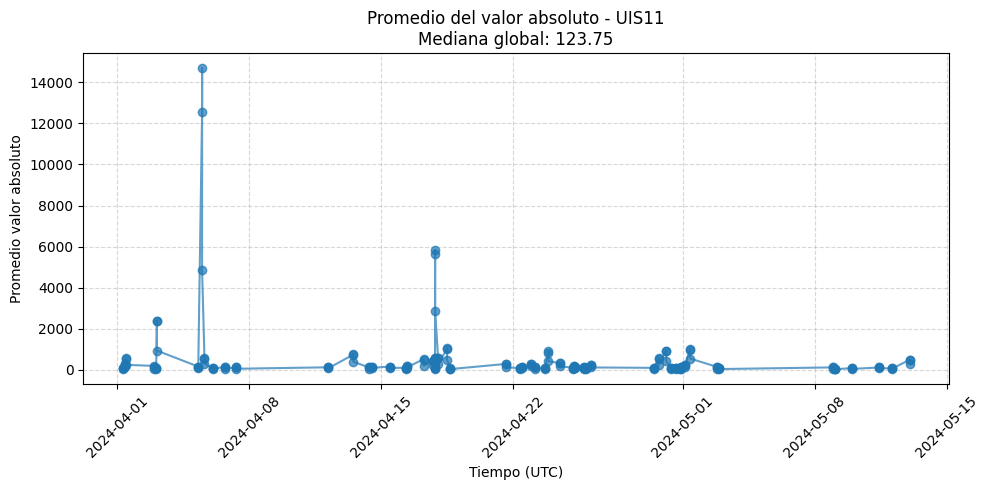

Estación UIS05_acceleration → Mediana global de promedios absolutos: 1517.03


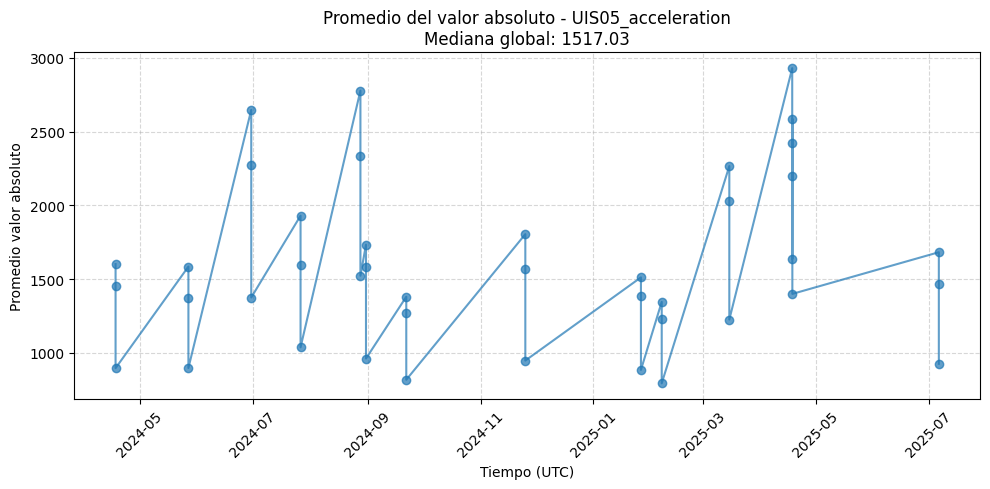

Estación UIS05_velocity → Mediana global de promedios absolutos: 307.51


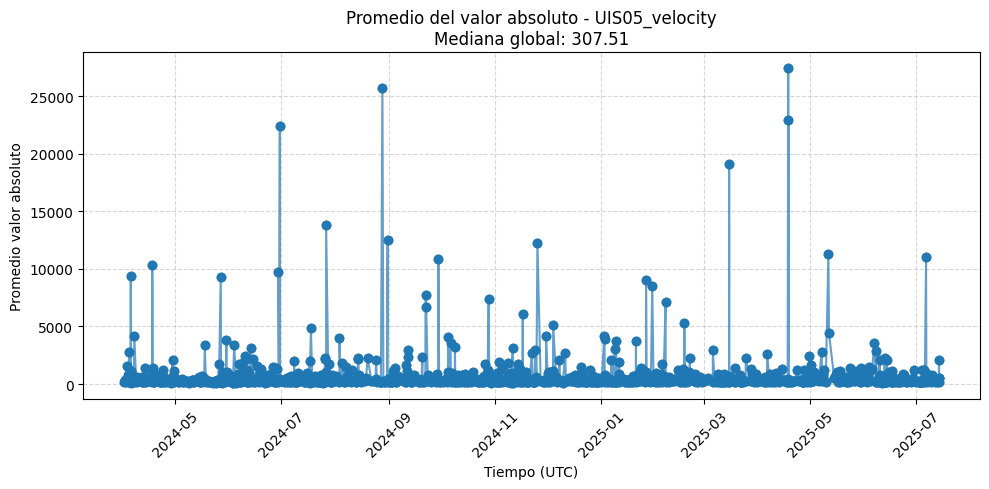

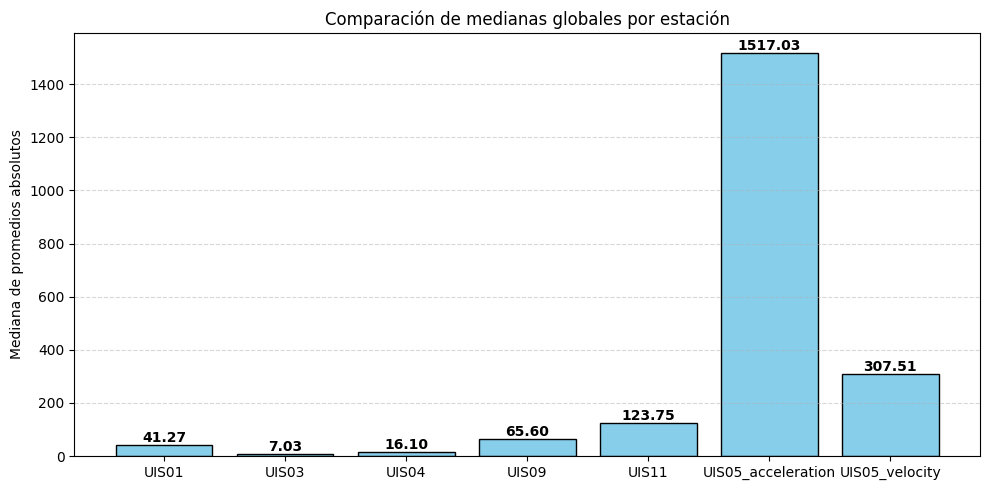

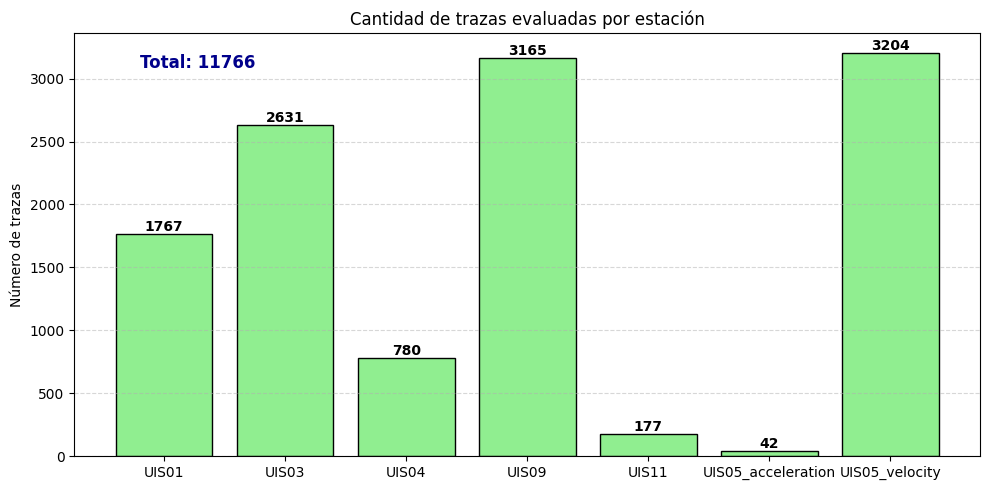

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from datetime import datetime

# Carpeta con los archivos mseed
input_folder = "E_mseed_eventos_umbrales_finales"

# Estaciones de interés
stations = ["UIS01", "UIS03", "UIS04", "UIS05", "UIS09", "UIS11"]

# Diccionario para guardar valores por estación (y sensor type en caso de UIS05)
station_data = {st: [] for st in stations}
station_data["UIS05_acceleration"] = []
station_data["UIS05_velocity"] = []

# Función para extraer fecha del nombre del archivo
def extract_time_from_filename(filename):
    parts = filename.split("_")
    start_time = None
    try:
        if parts[2][0:4].isdigit():
            start_time_str = parts[2]
            start_time = datetime.strptime(start_time_str, "%Y-%m-%dT%H-%M-%S")
        elif parts[4][0:4].isdigit():
            start_time_str = parts[4]
            start_time = datetime.strptime(start_time_str, "%Y-%m-%dT%H-%M-%S")
    except Exception as e:
        print(f"No pude extraer tiempo de {filename}: {e}")
    return start_time

# Recorremos los archivos en la carpeta
for filename in os.listdir(input_folder):
    if filename.endswith(".mseed"):
        filepath = os.path.join(input_folder, filename)
        try:
            st = read(filepath)
            for tr in st:
                data = tr.data.astype(float)
                mean_abs = np.mean(np.abs(data))
                start_time = extract_time_from_filename(filename)
                if start_time is None:
                    continue
                if "UIS05" in filename:
                    if "acceleration" in filename:
                        station_data["UIS05_acceleration"].append((start_time, mean_abs))
                    elif "velocity" in filename:
                        station_data["UIS05_velocity"].append((start_time, mean_abs))
                    else:
                        station_data["UIS05"].append((start_time, mean_abs))
                else:
                    for station in stations:
                        if station in filename:
                            station_data[station].append((start_time, mean_abs))
                            break
        except Exception as e:
            print(f"Error leyendo {filename}: {e}")

# --- Visualización y cálculo de estadísticas ---
medianas = {}  # Para guardar la mediana por estación

for station, data in station_data.items():
    if not data:
        continue

    # Ordenar por tiempo
    data = sorted(data, key=lambda x: x[0])
    times = [d[0] for d in data]
    values = [d[1] for d in data]

    # Calcular mediana
    median_station = np.median(values)
    medianas[station] = median_station
    print(f"Estación {station} → Mediana global de promedios absolutos: {median_station:.2f}")

    # Graficar por estación
    plt.figure(figsize=(10,5))
    plt.plot(times, values, 'o-', alpha=0.7)
    plt.title(f"Promedio del valor absoluto - {station}\nMediana global: {median_station:.2f}")
    plt.xlabel("Tiempo (UTC)")
    plt.ylabel("Promedio valor absoluto")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- Gráfico comparativo de medianas ---
plt.figure(figsize=(10,5))
stations_labels = list(medianas.keys())
median_values = list(medianas.values())

bars = plt.bar(stations_labels, median_values, color="skyblue", edgecolor="black")

plt.title("Comparación de medianas globales por estación")
plt.ylabel("Mediana de promedios absolutos")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Añadir valores encima de cada barra
for bar, value in zip(bars, median_values):
    plt.text(
        bar.get_x() + bar.get_width()/2,   # posición x (centro de la barra)
        bar.get_height(),                  # posición y (encima de la barra)
        f"{value:.2f}",                    # texto (2 decimales)
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.tight_layout()
plt.show()


# --- Gráfico de cantidad de trazas evaluadas por estación ---
plt.figure(figsize=(10,5))

# Usamos todas las claves de station_data que tengan datos
stations_labels = [st for st, data in station_data.items() if data]
trace_counts = [len(station_data[st]) for st in stations_labels]

bars = plt.bar(stations_labels, trace_counts, color="lightgreen", edgecolor="black")

plt.title("Cantidad de trazas evaluadas por estación")
plt.ylabel("Número de trazas")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Añadir valores encima de cada barra
for bar, count in zip(bars, trace_counts):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        str(count),
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

# Calcular total de trazas
total_traces = sum(trace_counts)

# Mostrar total en la esquina superior derecha del gráfico
plt.text(
    0.2, 0.95,
    f"Total: {total_traces}",
    ha="right", va="top",
    transform=plt.gca().transAxes,
    fontsize=12, fontweight="bold", color="darkblue"
)

plt.tight_layout()
plt.show()

